# Milestone 2 - Deep Learning model for sexism detection

In [1]:
import sys
import wandb
import os
import pandas as pd
import numpy as np

In [2]:
train_parquet = "../data_submission/train_dataset.parquet"
dev_parquet = "../data_submission/dev_dataset.parquet"
test_parquet = "../data_submission/test_dataset.parquet"

In [3]:
def load_processed_data(split=None):
    # Load the full dataset if no specific split is requested
    if split is None:
        split = ["train", "dev", "test"]

    # Load specified split datasets
    split_dataframes = {}
    paths = {
        "train": train_parquet,
        "dev": dev_parquet,
        "test": test_parquet,
    }
    # Load each specified split from paths dictionary
    for split_type in split:
        split_dataset_path = paths.get(split_type)
        if split_dataset_path and os.path.exists(split_dataset_path):
            split_dataframes[split_type] = pd.read_parquet(split_dataset_path)
            print(f"df: {split_type.capitalize()} split loaded.")
        else:
            print(f"Warning: {split_type} split file not found.")

    return split_dataframes

In [5]:
import torch
SEED = 8172003

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print(f"{torch.cuda.is_available() = }")
print(f"{torch.version.cuda = }")

torch.cuda.is_available() = True
torch.version.cuda = '11.8'


In [7]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\thoma\_netrc


True

## Data loading and formatting

In [8]:
TRAIN_RATIO = 0.01
BATCH_SIZE = 32
EPOCHS = 10

df_all = load_processed_data(['train', 'test', 'dev'])
df_train = df_all['train'].sample(frac=TRAIN_RATIO, random_state=SEED)
df_test = df_all['test']
df_valid = df_all['dev']

df_train.head()

df: Train split loaded.
df: Test split loaded.
df: Dev split loaded.


,text,label,split,lemma,pos,user_count,url_count
13596,You need to talk to your own lawyer. Debt and ...,0,train,"[""you"",""need"",""talk"",""your"",""own"",""lawyer"",""de...","[""PRON"",""VERB"",""VERB"",""PRON"",""ADJ"",""NOUN"",""NOU...",0,0
12948,"""Brown skin"" male sexually assaulted THREE tee...",0,train,"[""Brown"",""skin"",""male"",""sexually"",""assault"",""t...","[""PROPN"",""NOUN"",""NOUN"",""ADV"",""VERB"",""NUM"",""ADJ...",0,1
4004,"Just think of this typical scenario Man: ""When...",0,train,"[""think"",""typical"",""scenario"",""man"",""I"",""be"",""...","[""VERB"",""ADJ"",""NOUN"",""NOUN"",""PRON"",""AUX"",""ADJ""...",0,0
8003,I was raped as a sophomore in HS. I was also a...,0,train,"[""I"",""be"",""rape"",""sophomore"",""HS"",""I"",""be"",""al...","[""PRON"",""AUX"",""VERB"",""NOUN"",""PROPN"",""PRON"",""AU...",0,0
6949,cant wait til third world takes over the USA a...,1,train,"[""cant"",""wait"",""till"",""third"",""world"",""take"",""...","[""AUX"",""VERB"",""ADP"",""ADJ"",""NOUN"",""VERB"",""ADP"",...",0,0


In [9]:
label2id = {"Sexist" : 1, "Not Sexist" : 0}
id2label = {0: "Not Sexist", 1: "Sexist"}

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, BertForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer

model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [11]:
ds_train = Dataset.from_pandas(df_train.loc[:, ['label', 'text']], split='train')
ds_train

Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 140
})

In [12]:
ds_train[0]

{'label': 0,
 'text': 'You need to talk to your own lawyer. Debt and property from before the marriage should remain with original owner. Any assets or debt acquired after marriage is split 50/50. That includes things she will try to say are hers, like jewelry.',
 '__index_level_0__': 13596}

In [13]:
def convert_and_tokenize(examples):
    text = examples["text"]
    encoding = tokenizer(text, padding=True, truncation=True, max_length=128)
    encoding["labels"] = examples['label']

    return encoding

In [14]:
ds_train = ds_train.map(convert_and_tokenize, batched=True, batch_size=64, remove_columns=ds_train.column_names)

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

In [15]:
ds_train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})

In [16]:
tokenizer.decode(ds_train[32]['input_ids'])

'[CLS] men want to be needed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [17]:
ds_train.set_format("torch")

In [18]:
ds_test = Dataset.from_pandas(df_test.loc[:, ['label', 'text']])
ds_test = ds_test.map(convert_and_tokenize, batched=True, batch_size=BATCH_SIZE, remove_columns=ds_test.column_names)
ds_test.set_format("torch")

ds_valid = Dataset.from_pandas(df_valid.loc[:, ['label', 'text']])
ds_valid = ds_valid.map(convert_and_tokenize, batched=True, batch_size=BATCH_SIZE, remove_columns=ds_valid.column_names)
ds_valid.set_format("torch")

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Model loading and finetuning

In [34]:
model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path,
                                          problem_type="single_label_classification",
                                          num_labels=2,
                                          id2label=id2label,
                                          label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

In [35]:
from transformers import EvalPrediction
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

def binary_metrics(predictions, labels):
    y_pred = np.argmax(predictions, axis=-1)
    y_true = labels
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    bal_acc = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    sven_metric = 1
    metrics = {'f1': f1,
               'balanced_accuracy': bal_acc,
               'accuracy': accuracy,
               'Sven': sven_metric}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = binary_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [36]:
METRIC = "balanced_accuracy"
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    f"./model-finetuned_sexism-detection",
    overwrite_output_dir=True,
    report_to="wandb",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    save_steps=3,
    save_total_limit=1,
    logging_dir=f"./logs_sexism-detection_{current_date}",
    logging_steps=10,
    seed=SEED,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,
    learning_rate=1E-4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC,
    greater_is_better=True,
)

In [37]:
trainer_toxic = Trainer(
    model,
    args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=7)]
)

In [38]:
trainer_toxic.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=50, training_loss=0.44166687488555906, metrics={'train_runtime': 284.783, 'train_samples_per_second': 4.916, 'train_steps_per_second': 0.176, 'total_flos': 27890596826400.0, 'train_loss': 0.44166687488555906, 'epoch': 10.0})

In [39]:
wandb.finish()

eval/accuracy,▅█▅▁▃▂▂▂▂▁
eval/balanced_accuracy,▁▃▅▅▆█▆▆▇█
eval/f1,▁▁▄▆▆█▆▆▇█
eval/loss,▃▁▁▁▃▄▅▇██
eval/runtime,▁▃▄▄▆▆█▇▆▄
eval/samples_per_second,█▅▄▄▃▂▁▁▂▄
eval/steps_per_second,█▅▄▄▃▂▁▁▂▄
train/epoch,▁▂▂▃▃▃▄▅▅▆▆▆▇███
train/global_step,▁▂▂▃▃▃▄▅▅▆▆▆▇███
train/grad_norm,▅▄▁█▇
train/learning_rate,█▆▅▃▁


In [33]:
trainer_toxic.evaluate()

Error: You must call wandb.init() before wandb.log()

In [35]:
test_pred = trainer_toxic.predict(test_dataset=ds_test)

In [40]:
logits = test_pred.predictions

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [ ]:
np.softmax

In [42]:
logits_exp = np.exp(logits)
# Divide by the sum of exponents along the specified axis
softmax_probs = logits_exp / np.sum(logits_exp, axis=-1, keepdims=True)

In [54]:
softmax_probs.shape

(4000, 2)

In [53]:
logits.shape

(4000, 2)

In [56]:
np.argmax(softmax_probs, axis=-1, keepdims=True).shape

(4000, 1)

In [51]:
cutoff = 0.25
softmax_probs > cutoff

NameError: name 'softmax_probs' is not defined

In [83]:
C = np.hstack([np.argmax(logits, axis=-1, keepdims=True), softmax_probs, logits])

In [84]:
df_output = pd.DataFrame(C, columns=["y_pred", "prob_0", "prob_1", "logit_0", "logit_1"])

In [85]:
df_output = pd.concat([df_test['label'], df_output], axis=1)
df_output['y_pred'] = df_output['y_pred'].astype(int)
df_output.rename(columns={'label' : 'y_true'})

,y_true,y_pred,prob_0,prob_1,logit_0,logit_1
0,0,1,0.081155,0.918845,-1.457788,0.968966
1,1,1,0.239404,0.760596,-0.766639,0.389313
2,0,1,0.186122,0.813878,-0.942610,0.532795
3,1,0,0.966872,0.033128,1.483588,-1.890090
4,1,1,0.495746,0.504254,-0.073781,-0.056764
...,...,...,...,...,...,...
3995,0,0,0.842376,0.157624,0.643424,-1.032590
3996,1,0,0.908636,0.091364,0.944283,-1.352811
3997,0,0,0.747841,0.252159,0.394681,-0.692449
3998,0,0,0.943093,0.056907,1.200612,-1.607137


In [86]:
df_output.dtypes

label        int64
y_pred       int32
prob_0     float64
prob_1     float64
logit_0    float64
logit_1    float64
dtype: object

In [87]:
df_output.to_parquet("dl_predictions.parquet", index=True)

In [88]:
df_try = pd.read_parquet("dl_predictions.parquet")

In [89]:
df_try

,label,y_pred,prob_0,prob_1,logit_0,logit_1
0,0,1,0.081155,0.918845,-1.457788,0.968966
1,1,1,0.239404,0.760596,-0.766639,0.389313
2,0,1,0.186122,0.813878,-0.942610,0.532795
3,1,0,0.966872,0.033128,1.483588,-1.890090
4,1,1,0.495746,0.504254,-0.073781,-0.056764
...,...,...,...,...,...,...
3995,0,0,0.842376,0.157624,0.643424,-1.032590
3996,1,0,0.908636,0.091364,0.944283,-1.352811
3997,0,0,0.747841,0.252159,0.394681,-0.692449
3998,0,0,0.943093,0.056907,1.200612,-1.607137


# Metrics

In [71]:
from utils.metrics import plot_confusion_matrix, plot_calibration_curve, plot_probability_distribution, plot_boxplot_predicted_probabilities, plot_balanced_accuracy_vs_cutoff, plot_roc_curve_with_optimal_point, print_classification_report

In [72]:
df_output = pd.read_csv("../data_submission/dl_predictions.csv", index_col=0)
df_output.head(2)

,label,y_pred,prob_0,prob_1,logit_0,logit_1
0,0,0,0.986504,0.013496,1.950703,-2.341058
1,1,1,0.213531,0.786469,-0.851402,0.452371


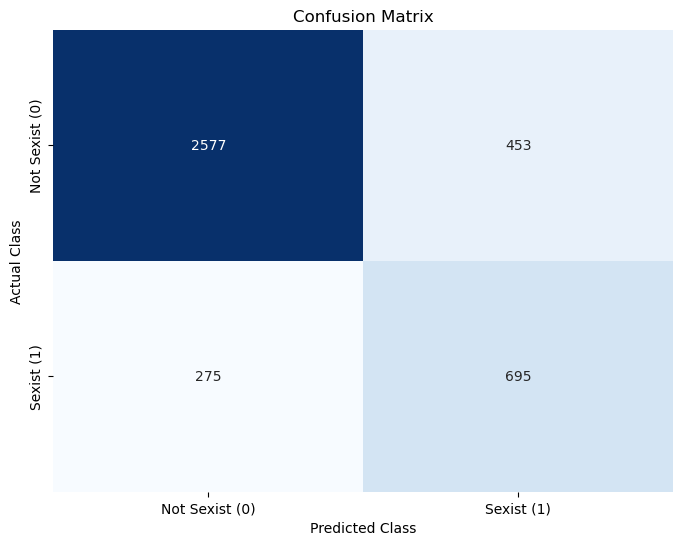

In [73]:
plot_confusion_matrix(df_output)

In [74]:
print_classification_report(df_output)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      3030
           1       0.61      0.72      0.66       970

    accuracy                           0.82      4000
   macro avg       0.75      0.78      0.77      4000
weighted avg       0.83      0.82      0.82      4000


In [75]:
df_output['y_pred'] = (df_output['prob_1'] > 0.25)

In [76]:
print_classification_report(df_output)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      3030
           1       0.53      0.82      0.65       970

    accuracy                           0.78      4000
   macro avg       0.73      0.79      0.74      4000
weighted avg       0.83      0.78      0.79      4000


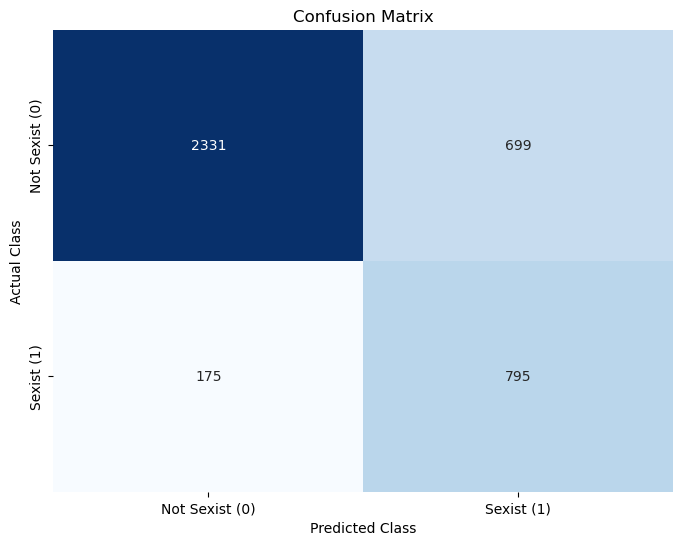

In [78]:
plot_confusion_matrix(df_output)

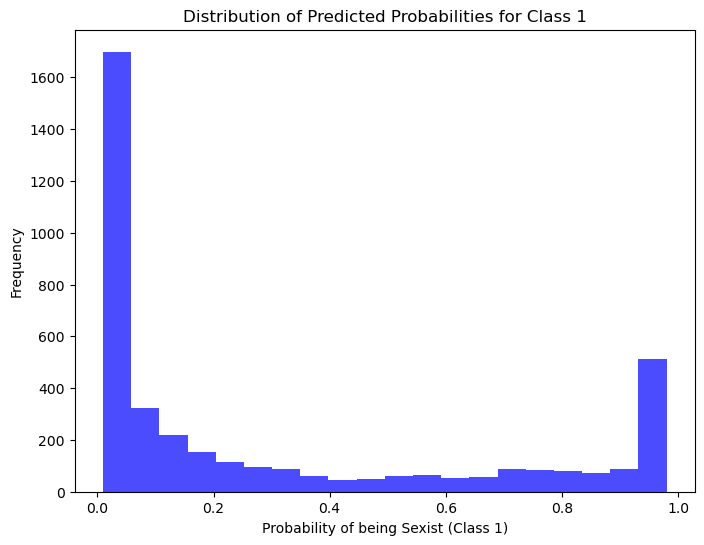

In [83]:
plot_probability_distribution(df_output)

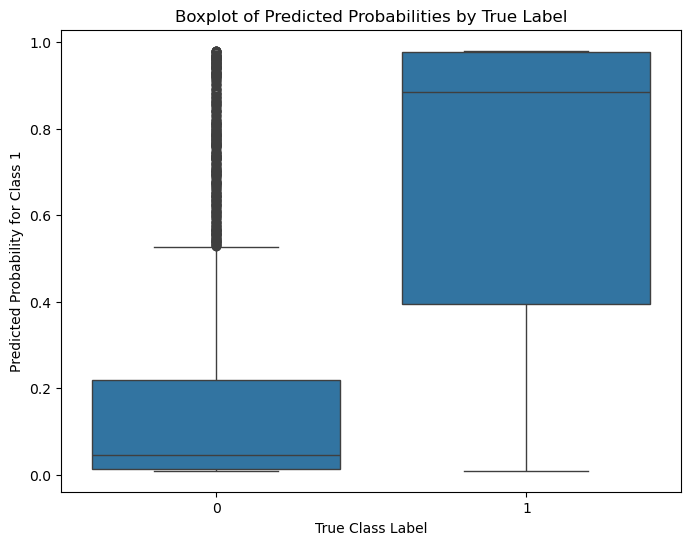

In [84]:
plot_boxplot_predicted_probabilities(df_output)